# Imports

In [1]:
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
warnings.filterwarnings('ignore',category=DeprecationWarning)

import tensorflow as tf

import cv2
import os

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import seaborn as sns
import pandas as pd
import re
import os

from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, model_from_json, Model

from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.layers import Conv2D, MaxPooling2D, MaxPool2D, LeakyReLU, Activation
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization, SeparableConv2D
from keras.layers import Input, ZeroPadding2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.preprocessing import image
from keras.utils import layer_utils
import keras.backend as K
K.set_image_data_format('channels_last')
from keras.optimizers import Adam
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split, KFold
from sklearn.utils import class_weight

from sklearn.metrics import roc_curve, roc_auc_score

from keras.models import  load_model

RSEED = 3    # Vamos usar a mesma seed para tudo
image_size = 180    # tamanho na imagem para o qual vamos normalizar -> [180,180]

# 1.  Balanced + Cross Validation

**1.1. Visualizar a data**

1.1.1 Dar import as imagens de treino e test e obter o set de validação

Vai ser usado um split de 80:20 entre treino e validação

In [2]:
# Imagens de TREINO e VALIDAÇÃO
files_train = tf.io.gfile.glob('chest_xray/train/*/*')

# Fazer a divisão dos ficheiros de treino em 80% para treino e 20% para teste
train_imgs, val_imgs = train_test_split(files_train, test_size=0.2, random_state=RSEED)

# Imagens de TESTE
test_imgs = tf.io.gfile.glob('chest_xray/test/*/*')

1.1.2 Contar a quantidade de casos (Pneumonia ou Normal) em cada set

In [3]:
norm_IMG_Train = 0
arry_hist_train = []

for img in train_imgs:
    if "NORMAL" in img:
        norm_IMG_Train = norm_IMG_Train + 1
        arry_hist_train.append(0)

print("Normal images in the Training Set: ", norm_IMG_Train)


pneu_IMG_Train = 0

for img in train_imgs:
    if "PNEUMONIA" in img:
        pneu_IMG_Train = pneu_IMG_Train + 1
        arry_hist_train.append(1)

print("Pneumonia images in the Training Set: ", pneu_IMG_Train)

total_img_Train = norm_IMG_Train + pneu_IMG_Train
print("Total images in Training Set: ", total_img_Train)

#-----------------------------
print(' ')
#-----------------------------


# Fazer a contagem de imagens de Validação


norm_IMG_Val = 0
arry_hist_val = []

for img in val_imgs:
    if "NORMAL" in img:
        norm_IMG_Val = norm_IMG_Val + 1
        arry_hist_val.append(0)

print("Normal images in the Validation Set: ", norm_IMG_Val)


pneu_IMG_Val = 0

for img in val_imgs:
    if "PNEUMONIA" in img:
        pneu_IMG_Val = pneu_IMG_Val + 1
        arry_hist_val.append(1)

print("Pneumonia images in the Validation Set: ", pneu_IMG_Val)

total_img_Val = norm_IMG_Val + pneu_IMG_Val
print("Total images in Validation Set: ", total_img_Val)

#-----------------------------
print(' ')
#-----------------------------


# Fazer a contagem de imagens de Teste


norm_IMG_Test = 0
arry_hist_test = []

for img in test_imgs:
    if "NORMAL" in img:
        norm_IMG_Test = norm_IMG_Test + 1
        arry_hist_test.append(0)

print("Normal images in the Testing Set: ", norm_IMG_Test)


pneu_IMG_Test = 0

for img in test_imgs:
    if "PNEUMONIA" in img:
        pneu_IMG_Test = pneu_IMG_Test + 1
        arry_hist_test.append(1)

print("Pneumonia images in the Testing Set: ", pneu_IMG_Test)

total_img_Test = norm_IMG_Test + pneu_IMG_Test
print("Total images in Testing Set: ", total_img_Test)

Normal images in the Training Set:  1072
Pneumonia images in the Training Set:  3113
Total images in Training Set:  4185
 
Normal images in the Validation Set:  277
Pneumonia images in the Validation Set:  770
Total images in Validation Set:  1047
 
Normal images in the Testing Set:  234
Pneumonia images in the Testing Set:  390
Total images in Testing Set:  624


Podemos ver que existem mais casos de Pneumonia do que Normal, o que indica que a data está unbalanced. Vamos vizualizar os Histogramas

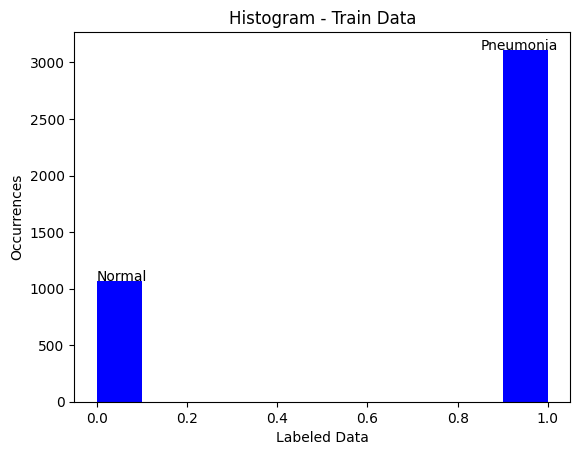

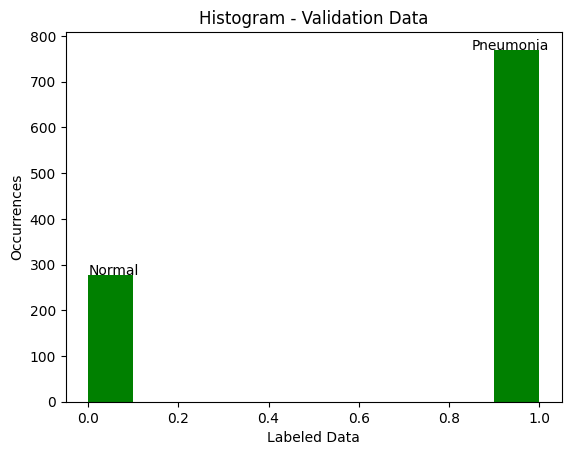

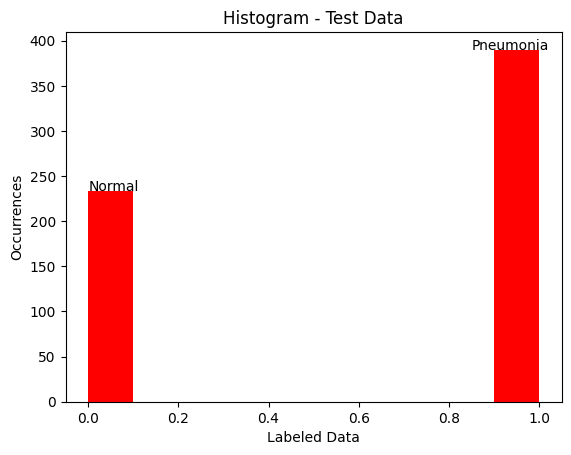

In [4]:
# Plotar histogramas
plt.hist(arry_hist_train, color = "blue")
plt.ylabel("Occurrences")
plt.xlabel("Labeled Data")
plt.title("Histogram - Train Data")
plt.annotate("Normal", (0, norm_IMG_Train))
plt.annotate("Pneumonia", (0.85, pneu_IMG_Train))
plt.show()

plt.hist(arry_hist_val, color = "green")
plt.ylabel("Occurrences")
plt.xlabel("Labeled Data")
plt.title("Histogram - Validation Data")
plt.annotate("Normal", (0, norm_IMG_Val))
plt.annotate("Pneumonia", (0.85, pneu_IMG_Val))
plt.show()

plt.hist(arry_hist_test, color = "red")
plt.ylabel("Occurrences")
plt.xlabel("Labeled Data")
plt.title("Histogram - Test Data")
plt.annotate("Normal", (0, norm_IMG_Test))
plt.annotate("Pneumonia", (0.85, pneu_IMG_Test))
plt.show()

**1.3 Data Setup**

In [5]:
labels = ['NORMAL', 'PNEUMONIA']
img_size = 180
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #read black and white
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [6]:
def get_train(indx):

    data = get_data('C:\\Users\\gfrei\\Documents\\chest_xray\\train')

    l = []
    for i in data:
        if(i[1] == 0):
            l.append(labels[0])
        else:
            l.append(labels[1])

    if indx == 1:
        sns.set_style('darkgrid')
        sns.countplot(l)

        plt.figure(figsize = (5,5))
        plt.imshow(data[1][0])
        plt.title(labels[data[0][1]])

        plt.figure(figsize = (5,5))
        plt.imshow(data[-1][0])
        plt.title(labels[data[-1][1]])

    x = []
    y = []

    for feature, label in data:
        x.append(feature)
        y.append(label)

    x = np.array(x) / image_size
    y = np.array(y).reshape((-1,1))

    return x,y

In [7]:
def get_test(indx):

    data = get_data('C:\\Users\\gfrei\\Documents\\chest_xray\\test')
    
    l = []
    for i in data:
        if(i[1] == 0):
            l.append(labels[0])
        else:
            l.append(labels[1])

    if indx == 1:
        sns.set_style('darkgrid')
        sns.countplot(l)

        plt.figure(figsize = (5,5))
        plt.imshow(data[1][0])
        plt.title(labels[data[0][1]])

        plt.figure(figsize = (5,5))
        plt.imshow(data[-1][0])
        plt.title(labels[data[-1][1]])

    x = []
    y = []

    for feature, label in data:
        x.append(feature)
        y.append(label)

    x = np.array(x) / image_size
    y = np.array(y).reshape((-1,1))

    return x,y

In [8]:
x,y = get_train(0)

print(x.shape)
print(y.shape)

C:\Users\gfrei\AppData\Local\Temp\ipykernel_11468\2723779862.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


(5232, 180, 180, 3)
(5232, 1)


In [9]:
x_test,y_test = get_train(0)

print(x_test.shape)
print(y_test.shape)

C:\Users\gfrei\AppData\Local\Temp\ipykernel_11468\2723779862.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


(5232, 180, 180, 3)
(5232, 1)


**1.5 Data Split**

In [10]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=RSEED)

**1.6 Calcular os pesos para balancear a data**

In [11]:
weight_for_0 = (1 / norm_IMG_Train)*(total_img_Train)/2.0 
weight_for_1 = (1 / pneu_IMG_Train)*(total_img_Train)/2.0

class_weights = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.95
Weight for class 1: 0.67


**1.7 Construir o Modelo CNN**

Inspiração : https://towardsdatascience.com/deep-learning-for-detecting-pneumonia-from-x-ray-images-fc9a3d9fdba8

In [12]:
inputs = Input(shape=(180, 180, 3))

# First conv block
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Second conv block
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Third conv block
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Fourth conv block
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# Fifth conv block
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# FC layer
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(rate=0.7)(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.5)(x)
x = Dense(units=64, activation='relu')(x)
x = Dropout(rate=0.3)(x)

# Output layer
output = Dense(units=1, activation='sigmoid')(x)

# Cross Validation

**CV.1 Compilar o modelo**

Como o training set e o test set estão unbalanced, vamos apenas olhar para Precision e Recall

Vamos assumir um learning rate de 0.000001 (quanto mais pequeno mais 'smooth' é a curva, mas mais tempo demora a convergir)

In [13]:
METRICS = [
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
]


opt = Adam(learning_rate=0.000001)

# Creating model and compiling
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=METRICS)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 separable_conv2d (Separable  (None, 90, 90, 32)       688       
 Conv2D)                                                         
                                                                 
 separable_conv2d_1 (Separab  (None, 90, 90, 32)       1344  

**B.2 Cross Validation**

    pat = nº de epochs sem melhorias seguidas para o modelo parar

    save_best_only = guarda os pesos q devolvem menos loss

In [14]:
pat = 5
early_stopping = EarlyStopping(monitor='val_loss', patience=pat, verbose=1)

model_checkpoint = ModelCheckpoint('best_cv.h5', verbose=1, save_best_only=True)

def fit_and_evaluate(x_train, x_val, y_train, y_val, EPOCHS=20, steps=131):
    model = Model(inputs=inputs, outputs=output)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=METRICS)
    #model.summary()
    results = model.fit(
                x_train, y_train,
                epochs=EPOCHS,
                steps_per_epoch=steps,
                validation_data=(x_val, y_val),
                class_weight=class_weights,
                callbacks=[early_stopping, model_checkpoint]
            )
    print("Val Score: ", model.evaluate(x_val, y_val))
    return results


In [15]:
n_folds=10      # número de folds para o cross validations  
epochs=25       # nº de epochs
steps=200       # steps por epoch

model_history = [] 
x,y = get_train(0)
    
for i in range(n_folds):
    print("Training on Fold: ",i+1)
    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=RSEED)
    model_history.append(fit_and_evaluate(x_train, x_val, y_train, y_val, epochs, steps))
    print("======="*12, end="\n\n\n")

C:\Users\gfrei\AppData\Local\Temp\ipykernel_11468\2723779862.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


Training on Fold:  1
Epoch 1/25
200/200 [==============================] - ETA: 0s - loss: 0.6933 - precision: 0.7519 - recall: 0.7800
Epoch 1: val_loss improved from inf to 0.69307, saving model to fas_mnist_1.h5
200/200 [==============================] - 125s 591ms/step - loss: 0.6933 - precision: 0.7519 - recall: 0.7800 - val_loss: 0.6931 - val_precision: 0.7354 - val_recall: 1.0000
Epoch 2/25
200/200 [==============================] - ETA: 0s - loss: 0.6929 - precision: 0.7848 - recall: 0.8082
Epoch 2: val_loss improved from 0.69307 to 0.69283, saving model to fas_mnist_1.h5
200/200 [==============================] - 117s 587ms/step - loss: 0.6929 - precision: 0.7848 - recall: 0.8082 - val_loss: 0.6928 - val_precision: 0.7354 - val_recall: 1.0000
Epoch 3/25
200/200 [==============================] - ETA: 0s - loss: 0.6926 - precision: 0.8129 - recall: 0.8191
Epoch 3: val_loss improved from 0.69283 to 0.69222, saving model to fas_mnist_1.h5
200/200 [==============================] -

Epoch 23/25
200/200 [==============================] - ETA: 0s - loss: 0.4977 - precision: 0.9516 - recall: 0.8342
Epoch 23: val_loss improved from 0.45711 to 0.45044, saving model to fas_mnist_1.h5
200/200 [==============================] - 116s 581ms/step - loss: 0.4977 - precision: 0.9516 - recall: 0.8342 - val_loss: 0.4504 - val_precision: 0.9677 - val_recall: 0.7779
Epoch 24/25
200/200 [==============================] - ETA: 0s - loss: 0.4776 - precision: 0.9514 - recall: 0.8294
Epoch 24: val_loss improved from 0.45044 to 0.41599, saving model to fas_mnist_1.h5
200/200 [==============================] - 116s 581ms/step - loss: 0.4776 - precision: 0.9514 - recall: 0.8294 - val_loss: 0.4160 - val_precision: 0.9668 - val_recall: 0.7935
Epoch 25/25
200/200 [==============================] - ETA: 0s - loss: 0.4629 - precision: 0.9545 - recall: 0.8227
Epoch 25: val_loss improved from 0.41599 to 0.40262, saving model to fas_mnist_1.h5
33/33 [==============================] - 7s 199ms/ste

200/200 [==============================] - 123s 617ms/step - loss: 0.3598 - precision: 0.9664 - recall: 0.8140 - val_loss: 0.3527 - val_precision: 0.9734 - val_recall: 0.8078
Epoch 5/25
200/200 [==============================] - ETA: 0s - loss: 0.3460 - precision: 0.9701 - recall: 0.8224
Epoch 5: val_loss improved from 0.34726 to 0.34286, saving model to fas_mnist_1.h5
200/200 [==============================] - 121s 606ms/step - loss: 0.3460 - precision: 0.9701 - recall: 0.8224 - val_loss: 0.3429 - val_precision: 0.9693 - val_recall: 0.8195
Epoch 6/25
200/200 [==============================] - ETA: 0s - loss: 0.3542 - precision: 0.9714 - recall: 0.8185
Epoch 6: val_loss did not improve from 0.34286
200/200 [==============================] - 120s 602ms/step - loss: 0.3542 - precision: 0.9714 - recall: 0.8185 - val_loss: 0.3540 - val_precision: 0.9734 - val_recall: 0.8065
Epoch 7/25
200/200 [==============================] - ETA: 0s - loss: 0.3503 - precision: 0.9687 - recall: 0.8259
Epo

33/33 [==============================] - 7s 218ms/step - loss: 0.3334 - precision: 0.9755 - recall: 0.8260
Val Score:  [0.33340317010879517, 0.9754601120948792, 0.8259740471839905]


Training on Fold:  5
Epoch 1/25
200/200 [==============================] - ETA: 0s - loss: 0.3226 - precision: 0.9722 - recall: 0.8372
Epoch 1: val_loss did not improve from 0.32682
200/200 [==============================] - 129s 612ms/step - loss: 0.3226 - precision: 0.9722 - recall: 0.8372 - val_loss: 0.3311 - val_precision: 0.9756 - val_recall: 0.8299
Epoch 2/25
200/200 [==============================] - ETA: 0s - loss: 0.3280 - precision: 0.9708 - recall: 0.8448
Epoch 2: val_loss improved from 0.32682 to 0.32647, saving model to fas_mnist_1.h5
200/200 [==============================] - 121s 607ms/step - loss: 0.3280 - precision: 0.9708 - recall: 0.8448 - val_loss: 0.3265 - val_precision: 0.9742 - val_recall: 0.8351
Epoch 3/25
200/200 [==============================] - ETA: 0s - loss: 0.3184 - precision

Epoch 16/25
200/200 [==============================] - ETA: 0s - loss: 0.2936 - precision: 0.9746 - recall: 0.8612
Epoch 16: val_loss did not improve from 0.30253
200/200 [==============================] - 122s 610ms/step - loss: 0.2936 - precision: 0.9746 - recall: 0.8612 - val_loss: 0.3181 - val_precision: 0.9759 - val_recall: 0.8403
Epoch 17/25
200/200 [==============================] - ETA: 0s - loss: 0.2958 - precision: 0.9754 - recall: 0.8535
Epoch 17: val_loss did not improve from 0.30253
200/200 [==============================] - 121s 607ms/step - loss: 0.2958 - precision: 0.9754 - recall: 0.8535 - val_loss: 0.3131 - val_precision: 0.9760 - val_recall: 0.8442
Epoch 18/25
200/200 [==============================] - ETA: 0s - loss: 0.2881 - precision: 0.9748 - recall: 0.8587
Epoch 18: val_loss improved from 0.30253 to 0.30156, saving model to fas_mnist_1.h5
200/200 [==============================] - 122s 609ms/step - loss: 0.2881 - precision: 0.9748 - recall: 0.8587 - val_loss: 0.

Epoch 13: early stopping
33/33 [==============================] - 7s 207ms/step - loss: 0.2911 - precision: 0.9748 - recall: 0.8545
Val Score:  [0.2911318838596344, 0.9748148322105408, 0.8545454740524292]


Training on Fold:  8
Epoch 1/25
200/200 [==============================] - ETA: 0s - loss: 0.2724 - precision: 0.9749 - recall: 0.8699
Epoch 1: val_loss did not improve from 0.28097
200/200 [==============================] - 125s 615ms/step - loss: 0.2724 - precision: 0.9749 - recall: 0.8699 - val_loss: 0.2863 - val_precision: 0.9734 - val_recall: 0.8558
Epoch 2/25
200/200 [==============================] - ETA: 0s - loss: 0.2693 - precision: 0.9764 - recall: 0.8779
Epoch 2: val_loss did not improve from 0.28097
200/200 [==============================] - 121s 608ms/step - loss: 0.2693 - precision: 0.9764 - recall: 0.8779 - val_loss: 0.2970 - val_precision: 0.9775 - val_recall: 0.8481
Epoch 3/25
200/200 [==============================] - ETA: 0s - loss: 0.2672 - precision: 0.9798 - r

Epoch 1/25
200/200 [==============================] - ETA: 0s - loss: 0.2421 - precision: 0.9806 - recall: 0.8841
Epoch 1: val_loss improved from 0.25344 to 0.25297, saving model to fas_mnist_1.h5
200/200 [==============================] - 124s 606ms/step - loss: 0.2421 - precision: 0.9806 - recall: 0.8841 - val_loss: 0.2530 - val_precision: 0.9754 - val_recall: 0.8766
Epoch 2/25
200/200 [==============================] - ETA: 0s - loss: 0.2398 - precision: 0.9809 - recall: 0.8921
Epoch 2: val_loss improved from 0.25297 to 0.23866, saving model to fas_mnist_1.h5
200/200 [==============================] - 122s 608ms/step - loss: 0.2398 - precision: 0.9809 - recall: 0.8921 - val_loss: 0.2387 - val_precision: 0.9759 - val_recall: 0.8922
Epoch 3/25
200/200 [==============================] - ETA: 0s - loss: 0.2466 - precision: 0.9775 - recall: 0.8927
Epoch 3: val_loss did not improve from 0.23866
200/200 [==============================] - 121s 605ms/step - loss: 0.2466 - precision: 0.9775 -

**B.4 Calcular as metrics**

In [16]:
model = load_model('best_cv.h5')

x_test,y_test = get_test(0)

print(x_test.shape)
print(y_test.shape)

loss, prec, rec = model.evaluate(x_test,y_test)

F1 = 2 * (prec * rec) / (prec + rec)

print("Loss:",loss)
print("Precision: %.2f%%" % (prec*100))
print("Recall: %.2f%%" % (rec*100))
print("F1 Score: %.2f%%" % (F1*100))

ypred_bal = model.predict(x_test)

ypred_val_bal = np.array([1 if x > 0.5 else 0 for x in ypred_bal])

print(confusion_matrix(y_test, ypred_val_bal))
print('\n',classification_report(ypred_val_bal,y_test))

#ROC
FPR_B, TPR_B, Threshold_B = roc_curve(arry_hist_test, ypred_bal, pos_label=1)
#AUC
AUC_B = roc_auc_score(arry_hist_test, ypred_bal)

print('AUC Score:',AUC_B)

C:\Users\gfrei\AppData\Local\Temp\ipykernel_11468\2723779862.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


(624, 180, 180, 3)
(624, 1)
20/20 [==============================] - 5s 218ms/step - loss: 0.4300 - precision: 0.8221 - recall: 0.9359
Loss: 0.42997604608535767
Precision: 82.21%
Recall: 93.59%
F1 Score: 87.53%
20/20 [==============================] - 5s 224ms/step
[[155  79]
 [ 25 365]]

               precision    recall  f1-score   support

           0       0.66      0.86      0.75       180
           1       0.94      0.82      0.88       444

    accuracy                           0.83       624
   macro avg       0.80      0.84      0.81       624
weighted avg       0.86      0.83      0.84       624

AUC Score: 0.9268682884067498


# Gráficos ROC e valores de AUC

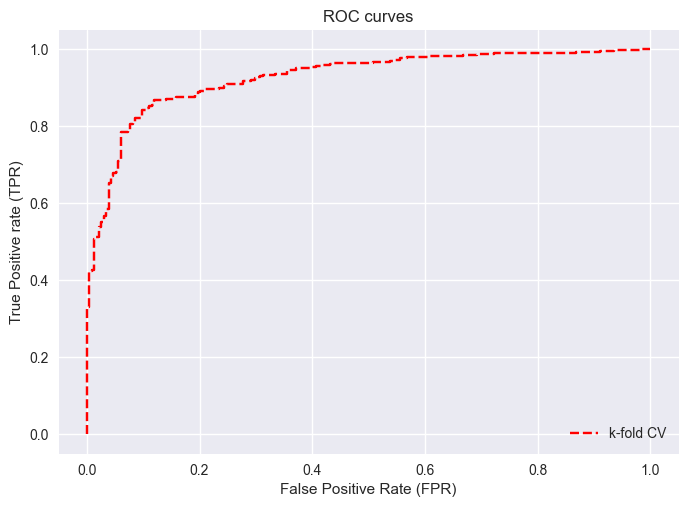

AUC Balanced: 0.9269


In [43]:
plt.style.use('seaborn')

plt.plot(FPR_B, TPR_B, linestyle='--',color='red', label='k-fold CV')

plt.title('ROC curves')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive rate (TPR)')
plt.legend(loc='lower right')
plt.savefig("CV_ROC.png")
plt.show()

print("AUC Balanced:", round(AUC_B,4))

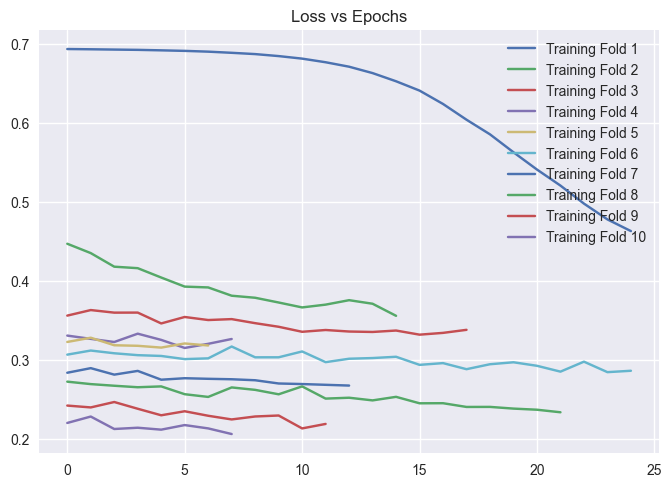

In [18]:
plt.title('Loss vs Epochs')
plt.plot(model_history[0].history['loss'], label='Training Fold 1')
plt.plot(model_history[1].history['loss'], label='Training Fold 2')
plt.plot(model_history[2].history['loss'], label='Training Fold 3')
plt.plot(model_history[3].history['loss'], label='Training Fold 4')
plt.plot(model_history[4].history['loss'], label='Training Fold 5')
plt.plot(model_history[5].history['loss'], label='Training Fold 6')
plt.plot(model_history[6].history['loss'], label='Training Fold 7')
plt.plot(model_history[7].history['loss'], label='Training Fold 8')
plt.plot(model_history[8].history['loss'], label='Training Fold 9')
plt.plot(model_history[9].history['loss'], label='Training Fold 10')
plt.legend()
plt.show()

# Predict Images

Podemos ver que deu predict mal a imagem

1/1 [==============================] - 0s 43ms/step
Normal


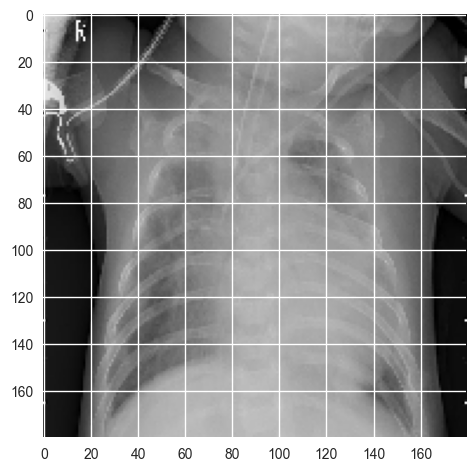

In [20]:
# Fazer predict de uma imagem

img_path = 'chest_xray/test/PNEUMONIA/person1_virus_6.jpeg'

img=tf.keras.utils.load_img(img_path, target_size=(180, 180))
imshow(img)

x = tf.keras.utils.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

if model.predict(x) == 0:
    print('Normal')
else:
    print('Pneumonia')